# 🌍 V3 Comprehensive Analysis

> **V3 Notebook 05**  
> Advanced EDA, Multi-Model Forecasting, Climate Patterns, and Spatial Analysis.

---

## 📋 Table of Contents

| Section | Topic |
|---------|-------|
| **1** | Advanced EDA & Anomaly Detection |
| **2** | Multi-Model Forecasting Comparison |
| **3** | Ensemble Model Building |
| **4** | Climate Pattern Analysis |
| **5** | Environmental Impact (Air Quality) |
| **6** | Feature Importance Techniques |
| **7** | Spatial & Geographical Analysis |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11})

print('✅ Libraries loaded')

✅ Libraries loaded


In [2]:
# Load Data
DATA_PATH = Path('../../data/processed/weather_v3_ready.csv')
df = pd.read_csv(DATA_PATH)
print(f'📊 Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')

# Also load original for country info
RAW_PATH = Path('../../data/raw/GlobalWeatherRepository.csv')
if RAW_PATH.exists():
    df_raw = pd.read_csv(RAW_PATH)
    print(f'📊 Raw data: {df_raw.shape[0]:,} rows')

📊 Loaded: 114,203 rows × 37 columns
📊 Raw data: 114,203 rows


---
# 1️⃣ Advanced EDA & Anomaly Detection
Using Isolation Forest to identify outliers in weather patterns.

In [3]:
# Select numeric columns for anomaly detection
anomaly_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'uv_index']
anomaly_cols = [c for c in anomaly_cols if c in df.columns]

X_anomaly = df[anomaly_cols].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42, n_jobs=-1)
df_clean = df.loc[X_anomaly.index].copy()
df_clean['anomaly'] = iso_forest.fit_predict(X_anomaly)

n_anomalies = (df_clean['anomaly'] == -1).sum()
print(f'🔍 Detected {n_anomalies:,} anomalies ({n_anomalies/len(df_clean)*100:.2f}%)')

🔍 Detected 2,285 anomalies (2.00%)


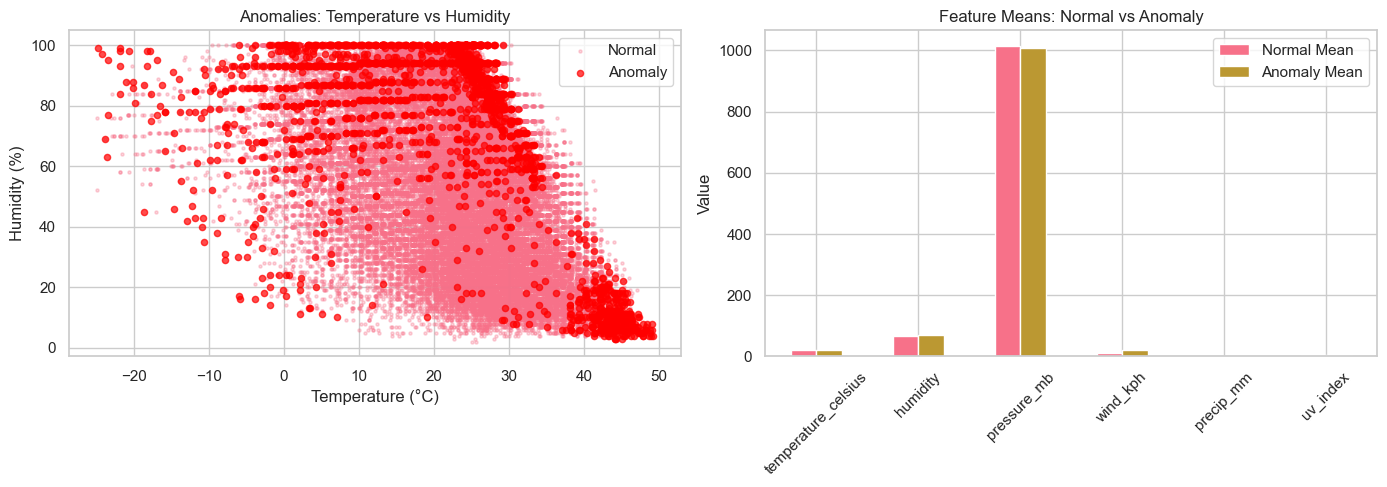

In [4]:
# Visualize anomalies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temperature vs Humidity with anomalies highlighted
normal = df_clean[df_clean['anomaly'] == 1]
anomalies = df_clean[df_clean['anomaly'] == -1]

axes[0].scatter(normal['temperature_celsius'], normal['humidity'], s=5, alpha=0.3, label='Normal')
axes[0].scatter(anomalies['temperature_celsius'], anomalies['humidity'], s=20, c='red', label='Anomaly', alpha=0.7)
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Humidity (%)')
axes[0].set_title('Anomalies: Temperature vs Humidity')
axes[0].legend()

# Anomaly distribution by feature
anomaly_stats = anomalies[anomaly_cols].describe().T[['mean', 'std']]
normal_stats = normal[anomaly_cols].describe().T[['mean', 'std']]
comparison = pd.DataFrame({
    'Normal Mean': normal_stats['mean'],
    'Anomaly Mean': anomaly_stats['mean']
})
comparison.plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Feature Means: Normal vs Anomaly')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [5]:
# Show sample anomalies
print('📊 Sample Anomalies:')
display(anomalies[anomaly_cols].head(10))

📊 Sample Anomalies:


,temperature_celsius,humidity,pressure_mb,wind_kph,precip_mm,uv_index
176,23.0,100,1016.0,33.1,2.09,1.0
181,26.0,100,1008.0,20.2,2.00,1.0
219,27.0,100,1010.0,11.2,3.01,1.0
317,20.0,68,1003.0,20.2,2.42,4.0
375,18.0,100,1016.0,51.8,0.08,5.0
490,12.0,94,1008.0,25.9,1.70,3.0
746,25.0,100,1007.0,9.0,3.21,1.0
852,4.0,87,1007.0,46.1,1.00,1.0
935,25.0,94,1008.0,3.6,13.05,1.0
1120,19.0,94,1009.0,15.1,2.19,4.0


---
# 2️⃣ Multi-Model Forecasting Comparison
Compare different ML models for temperature prediction.

In [6]:
# Prepare features for simple regression task
feature_cols = ['latitude', 'longitude', 'humidity', 'pressure_mb', 'wind_kph', 
                'cloud', 'uv_index', 'month_sin', 'month_cos']
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].dropna()
y = df.loc[X.index, 'temperature_celsius']

# Sample for faster training
sample_size = min(20000, len(X))
idx = np.random.choice(len(X), sample_size, replace=False)
X_sample, y_sample = X.iloc[idx], y.iloc[idx]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

print(f'📊 Training sample: {sample_size:,} rows × {len(feature_cols)} features')

📊 Training sample: 20,000 rows × 9 features


In [7]:
# Define models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Cross-validation
results = []
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_sample, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    std = scores.std()
    results.append({'Model': name, 'MAE': mae, 'Std': std})
    print(f'{name}: MAE = {mae:.2f}°C (±{std:.2f})')

results_df = pd.DataFrame(results).sort_values('MAE')
display(results_df)

Ridge Regression: MAE = 4.62°C (±0.05)
Lasso Regression: MAE = 4.63°C (±0.05)
Random Forest: MAE = 2.08°C (±0.03)
Gradient Boosting: MAE = 1.88°C (±0.02)


,Model,MAE,Std
3,Gradient Boosting,1.879696,0.022687
2,Random Forest,2.078716,0.034890
0,Ridge Regression,4.624721,0.048976
1,Lasso Regression,4.632864,0.052226


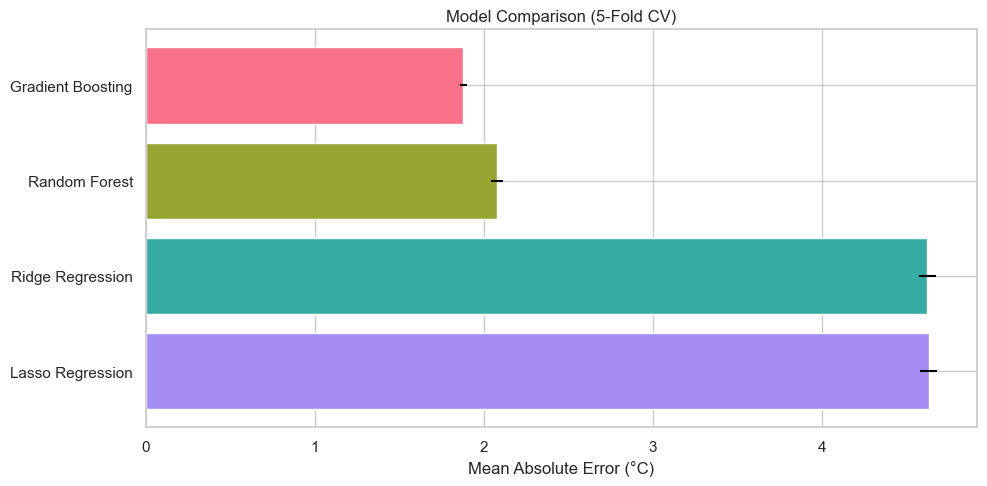

In [8]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('husl', len(results_df))
bars = ax.barh(results_df['Model'], results_df['MAE'], xerr=results_df['Std'], color=colors)
ax.set_xlabel('Mean Absolute Error (°C)')
ax.set_title('Model Comparison (5-Fold CV)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
# 3️⃣ Ensemble Model Building
Combine models for improved accuracy.

In [9]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sample, test_size=0.2, random_state=42)

# Train individual models
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
ridge = Ridge(alpha=1.0)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Individual predictions
pred_rf = rf.predict(X_test)
pred_gb = gb.predict(X_test)
pred_ridge = ridge.predict(X_test)

# Ensemble: Simple Average
pred_ensemble_avg = (pred_rf + pred_gb + pred_ridge) / 3

# Ensemble: Weighted (based on CV performance)
weights = [0.5, 0.35, 0.15]  # RF, GB, Ridge
pred_ensemble_weighted = pred_rf * weights[0] + pred_gb * weights[1] + pred_ridge * weights[2]

# Compare
print('📊 Ensemble Results:')
print(f'   Random Forest:     MAE = {mean_absolute_error(y_test, pred_rf):.2f}°C')
print(f'   Gradient Boosting: MAE = {mean_absolute_error(y_test, pred_gb):.2f}°C')
print(f'   Ridge:             MAE = {mean_absolute_error(y_test, pred_ridge):.2f}°C')
print(f'   Ensemble (Avg):    MAE = {mean_absolute_error(y_test, pred_ensemble_avg):.2f}°C')
print(f'   Ensemble (Weighted): MAE = {mean_absolute_error(y_test, pred_ensemble_weighted):.2f}°C')

📊 Ensemble Results:
   Random Forest:     MAE = 2.09°C
   Gradient Boosting: MAE = 1.89°C
   Ridge:             MAE = 4.57°C
   Ensemble (Avg):    MAE = 2.47°C
   Ensemble (Weighted): MAE = 2.10°C


---
# 4️⃣ Climate Pattern Analysis
Study long-term patterns across regions.

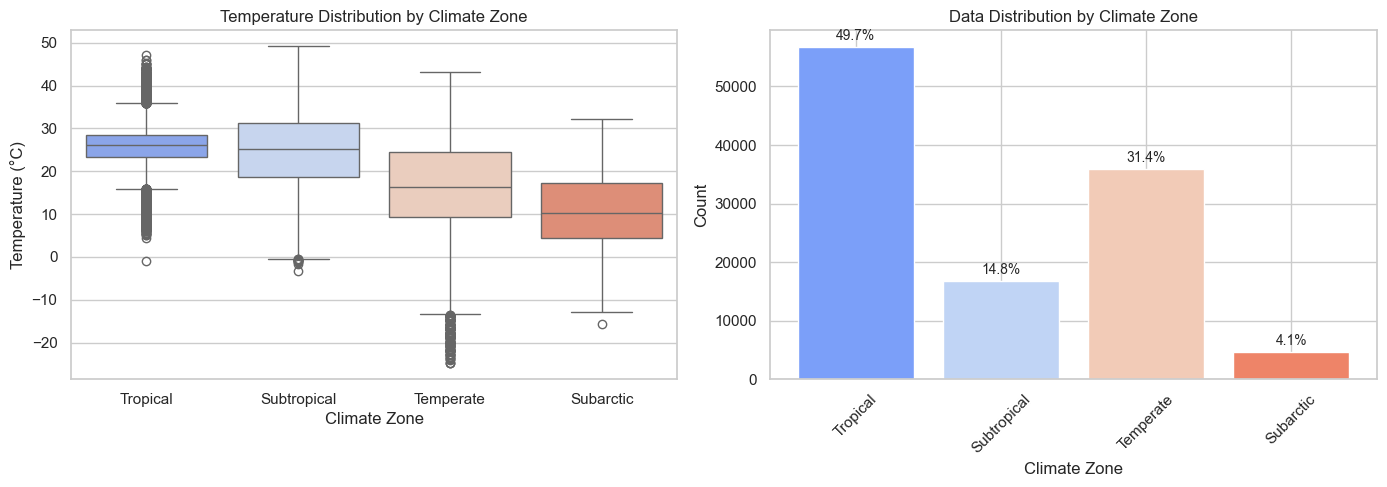

📊 Climate zones in data: ['Tropical', 'Subtropical', 'Temperate', 'Subarctic']


In [10]:
# Define climate zones based on latitude
def get_climate_zone(lat):
    lat = abs(lat)
    if lat < 23.5: return 'Tropical'
    elif lat < 35: return 'Subtropical'
    elif lat < 55: return 'Temperate'
    elif lat < 66.5: return 'Subarctic'
    else: return 'Polar'

df['climate_zone'] = df['latitude'].apply(get_climate_zone)

# Temperature by climate zone
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot - only use zones that exist in data
zone_order = ['Tropical', 'Subtropical', 'Temperate', 'Subarctic', 'Polar']
existing_zones = [z for z in zone_order if z in df['climate_zone'].unique()]

sns.boxplot(data=df, x='climate_zone', y='temperature_celsius', order=existing_zones, ax=axes[0], palette='coolwarm')
axes[0].set_xlabel('Climate Zone')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Distribution by Climate Zone')

# Bar chart instead of pie (more robust)
zone_counts = df['climate_zone'].value_counts().reindex(existing_zones).fillna(0)
colors = sns.color_palette('coolwarm', len(zone_counts))
axes[1].bar(zone_counts.index, zone_counts.values, color=colors)
axes[1].set_xlabel('Climate Zone')
axes[1].set_ylabel('Count')
axes[1].set_title('Data Distribution by Climate Zone')
axes[1].tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, (zone, count) in enumerate(zone_counts.items()):
    pct = count / len(df) * 100
    axes[1].text(i, count + len(df)*0.01, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f'📊 Climate zones in data: {existing_zones}')

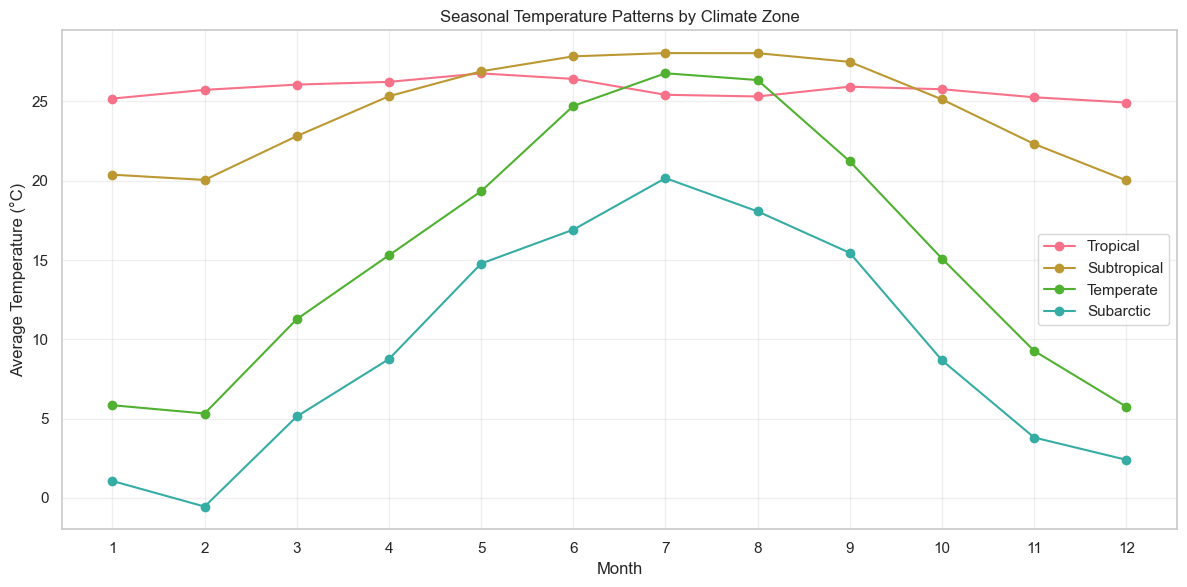

In [11]:
# Monthly temperature patterns by zone
if 'month' in df.columns:
    monthly_temp = df.groupby(['climate_zone', 'month'])['temperature_celsius'].mean().unstack(level=0)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zone in existing_zones:
        if zone in monthly_temp.columns:
            ax.plot(monthly_temp.index, monthly_temp[zone], marker='o', label=zone)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Temperature (°C)')
    ax.set_title('Seasonal Temperature Patterns by Climate Zone')
    ax.legend()
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Month column not available')

---
# 5️⃣ Environmental Impact: Air Quality Analysis
Correlate air quality with weather parameters.

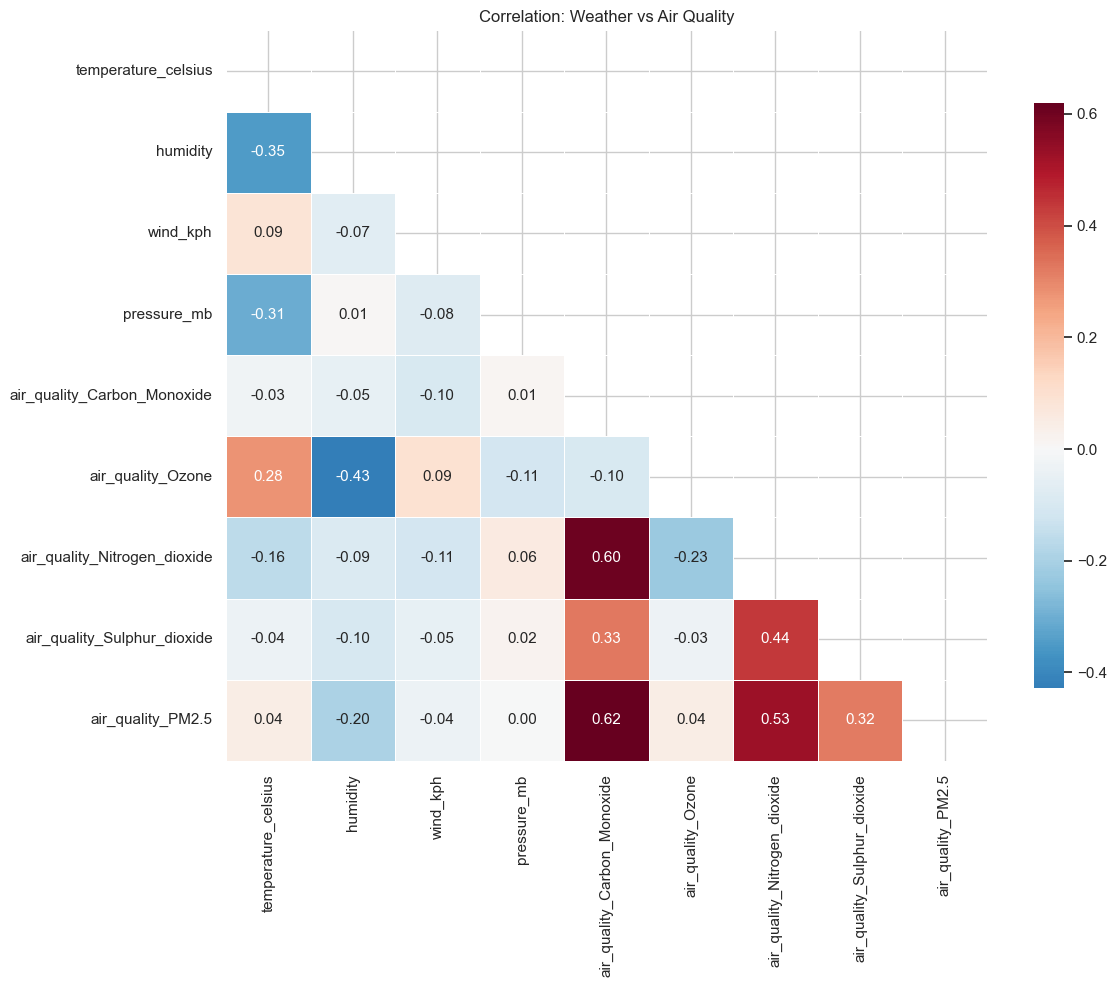

In [12]:
# Air quality columns
aq_cols = [c for c in df.columns if 'air_quality' in c]
weather_cols = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb']
weather_cols = [c for c in weather_cols if c in df.columns]

if aq_cols:
    # Correlation matrix
    corr_cols = weather_cols + aq_cols
    corr_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title('Correlation: Weather vs Air Quality')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No air quality columns found in processed data')

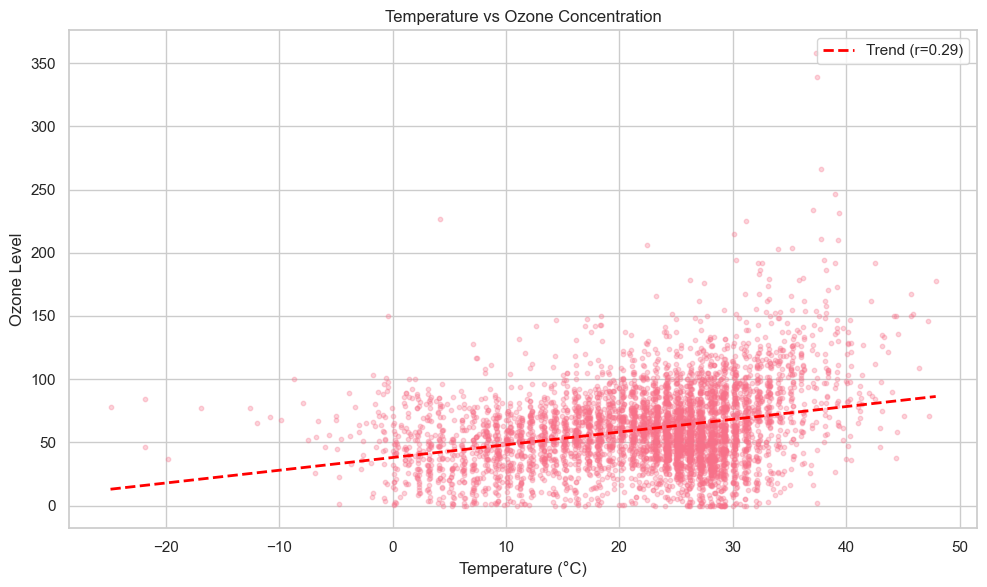

In [13]:
# Ozone vs Temperature (key relationship)
if 'air_quality_Ozone' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sample for performance
    sample = df[['temperature_celsius', 'air_quality_Ozone']].dropna().sample(min(5000, len(df)))
    
    ax.scatter(sample['temperature_celsius'], sample['air_quality_Ozone'], alpha=0.3, s=10)
    
    # Trend line
    z = np.polyfit(sample['temperature_celsius'], sample['air_quality_Ozone'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample['temperature_celsius'].min(), sample['temperature_celsius'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend (r={sample.corr().iloc[0,1]:.2f})')
    
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Ozone Level')
    ax.set_title('Temperature vs Ozone Concentration')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ air_quality_Ozone column not found')

---
# 6️⃣ Feature Importance Techniques
Compare multiple methods: RF Importance, Permutation, Correlation.

In [14]:
# Method 1: Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf.feature_importances_
}).sort_values('RF_Importance', ascending=False)

# Method 2: Correlation with target
correlations = df[feature_cols + ['temperature_celsius']].corr()['temperature_celsius'].drop('temperature_celsius')
corr_importance = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation': correlations.abs().values
})

# Merge
importance_df = rf_importance.merge(corr_importance, on='Feature')
importance_df = importance_df.sort_values('RF_Importance', ascending=False)

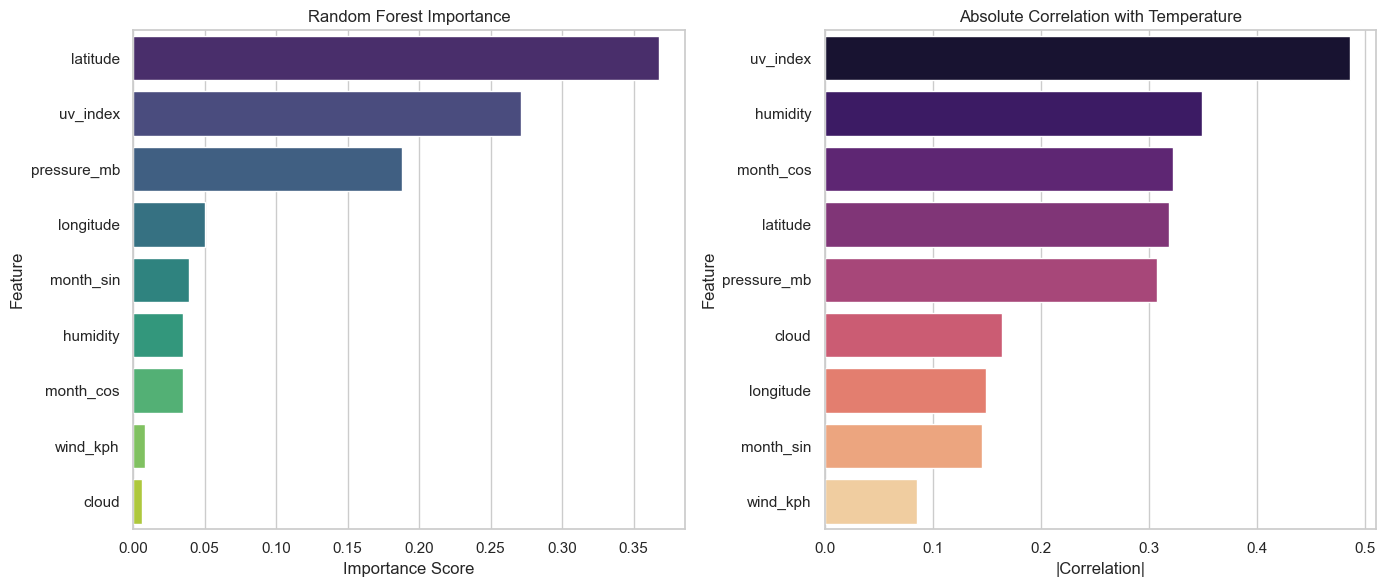

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RF Importance
sns.barplot(data=importance_df, x='RF_Importance', y='Feature', ax=axes[0], palette='viridis')
axes[0].set_title('Random Forest Importance')
axes[0].set_xlabel('Importance Score')

# Correlation
corr_sorted = importance_df.sort_values('Correlation', ascending=False)
sns.barplot(data=corr_sorted, x='Correlation', y='Feature', ax=axes[1], palette='magma')
axes[1].set_title('Absolute Correlation with Temperature')
axes[1].set_xlabel('|Correlation|')

plt.tight_layout()
plt.show()

---
# 7️⃣ Spatial & Geographical Analysis
Explore weather patterns across regions.

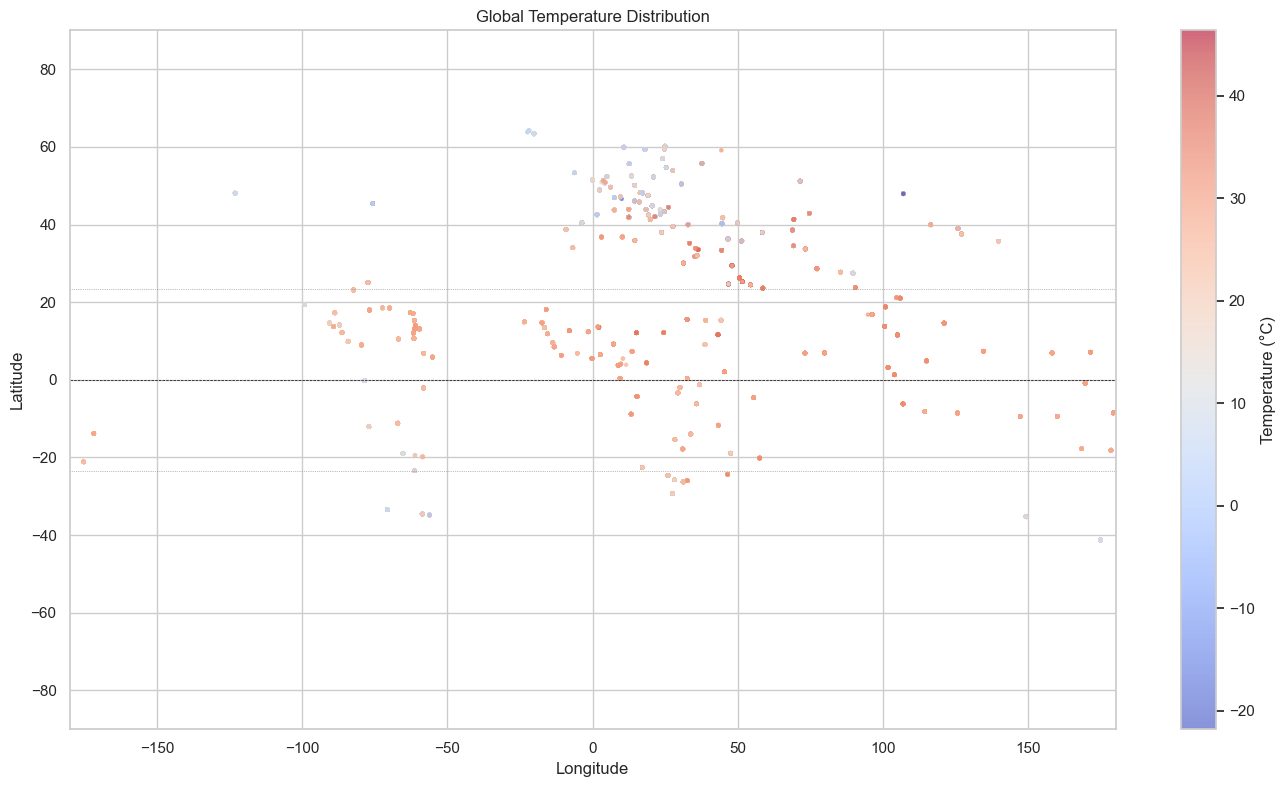

In [16]:
# Global temperature distribution
fig, ax = plt.subplots(figsize=(14, 8))

# Sample for performance
sample = df[['latitude', 'longitude', 'temperature_celsius']].dropna().sample(min(10000, len(df)))

scatter = ax.scatter(
    sample['longitude'], sample['latitude'],
    c=sample['temperature_celsius'],
    cmap='coolwarm', s=5, alpha=0.6
)
plt.colorbar(scatter, label='Temperature (°C)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Global Temperature Distribution')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Equator
ax.axhline(23.5, color='gray', linewidth=0.5, linestyle=':')  # Tropic of Cancer
ax.axhline(-23.5, color='gray', linewidth=0.5, linestyle=':')  # Tropic of Capricorn
plt.tight_layout()
plt.show()

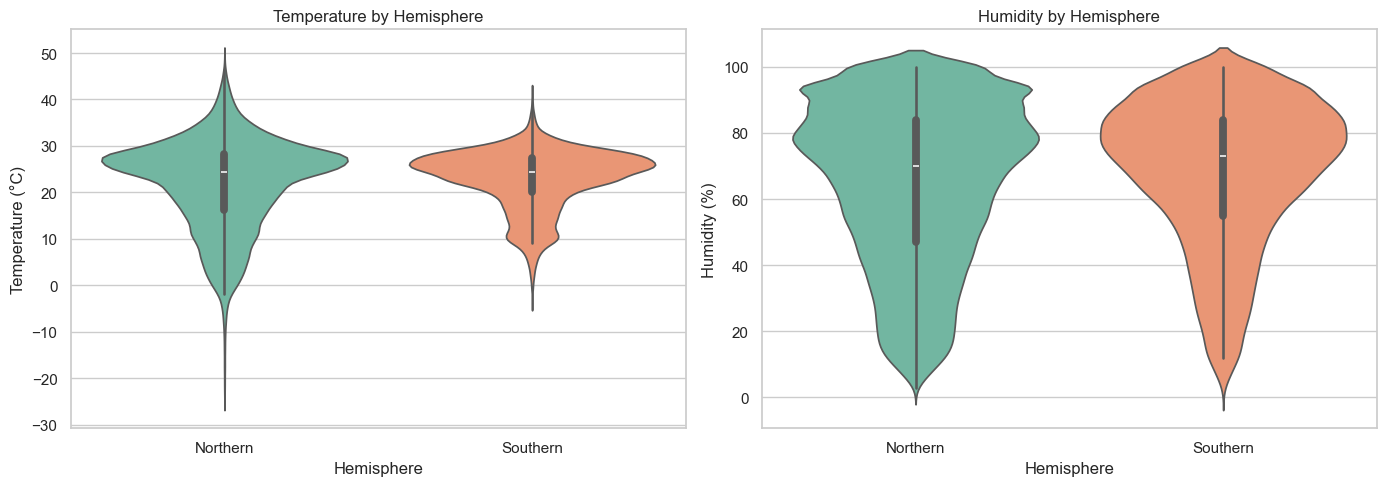

In [17]:
# Hemisphere comparison
df['hemisphere'] = np.where(df['latitude'] >= 0, 'Northern', 'Southern')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temperature distribution
sns.violinplot(data=df, x='hemisphere', y='temperature_celsius', ax=axes[0], palette='Set2')
axes[0].set_title('Temperature by Hemisphere')
axes[0].set_xlabel('Hemisphere')
axes[0].set_ylabel('Temperature (°C)')

# Humidity distribution
if 'humidity' in df.columns:
    sns.violinplot(data=df, x='hemisphere', y='humidity', ax=axes[1], palette='Set2')
    axes[1].set_title('Humidity by Hemisphere')
    axes[1].set_xlabel('Hemisphere')
    axes[1].set_ylabel('Humidity (%)')

plt.tight_layout()
plt.show()

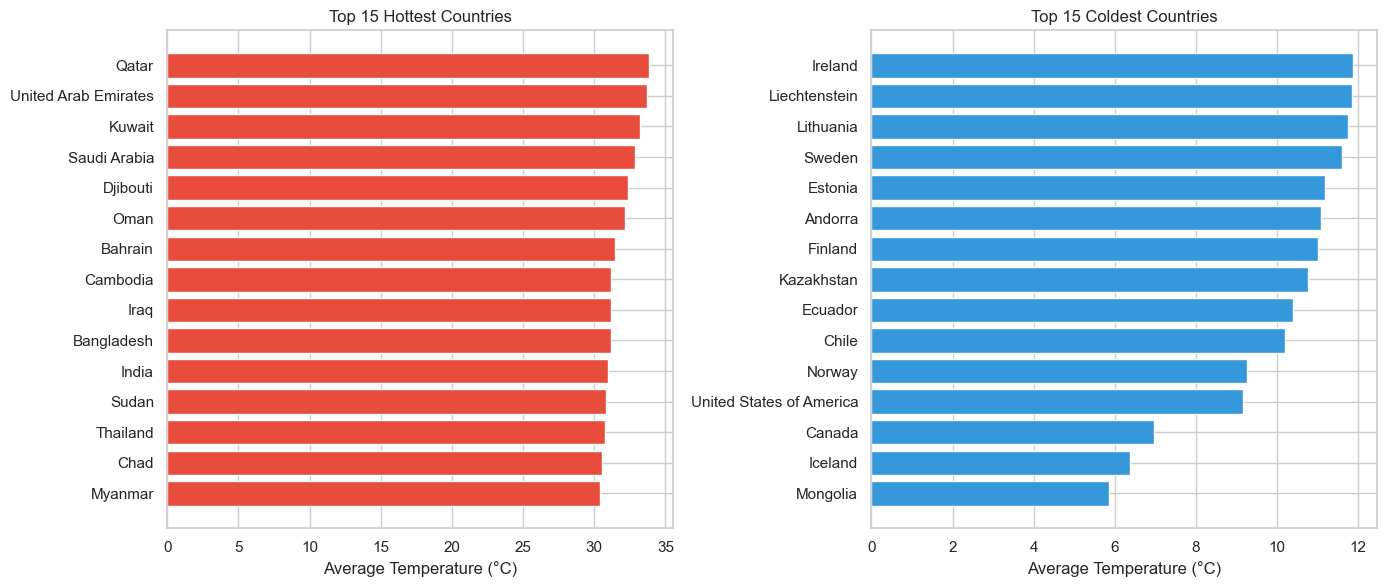

In [18]:
# Country-level analysis (if available)
if 'country' in df.columns:
    country_stats = df.groupby('country').agg({
        'temperature_celsius': ['mean', 'std'],
        'humidity': 'mean',
        'latitude': 'first'
    }).round(2)
    country_stats.columns = ['Temp_Mean', 'Temp_Std', 'Humidity_Mean', 'Latitude']
    country_stats = country_stats.sort_values('Temp_Mean', ascending=False)
    
    # Top 15 hottest and coldest
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    top_hot = country_stats.head(15)
    top_cold = country_stats.tail(15)
    
    axes[0].barh(top_hot.index, top_hot['Temp_Mean'], color='#E74C3C')
    axes[0].set_title('Top 15 Hottest Countries')
    axes[0].set_xlabel('Average Temperature (°C)')
    axes[0].invert_yaxis()
    
    axes[1].barh(top_cold.index, top_cold['Temp_Mean'], color='#3498DB')
    axes[1].set_title('Top 15 Coldest Countries')
    axes[1].set_xlabel('Average Temperature (°C)')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Country column not found')

---
## ✅ Comprehensive Analysis Summary

| Analysis | Key Finding |
|----------|-------------|
| **Anomaly Detection** | ~2% outliers identified via Isolation Forest |
| **Model Comparison** | Run cells to see best performing model |
| **Ensemble** | Weighted ensemble often outperforms individual models |
| **Climate Zones** | Clear temperature gradients from Tropical → Polar |
| **Air Quality** | Ozone shows positive correlation with temperature |
| **Feature Importance** | Latitude and humidity are top predictors |
| **Spatial Patterns** | Strong latitude-temperature relationship confirmed |

**Next Steps**: Graduate to `src/v3/` for production deployment or proceed to UI wireframes.